# Recommender System

## Importing Dependencies and Loading Our Dataset

In [1]:
%matplotlib inline
import json
import pickle
from ast import literal_eval
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import sqlite3
from sqlalchemy import create_engine
import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('Resources/tmdb_5000_movies.csv')
df.head().T

,0,1,2,3,4
budget,237000000,300000000,245000000,250000000,260000000
genres,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
homepage,http://www.avatarmovie.com/,http://disney.go.com/disneypictures/pirates/,http://www.sonypictures.com/movies/spectre/,http://www.thedarkknightrises.com/,http://movies.disney.com/john-carter
id,19995,285,206647,49026,49529
keywords,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":..."
original_language,en,en,en,en,en
original_title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter
overview,"In the 22nd century, a paraplegic Marine is di...","Captain Barbossa, long believed to be dead, ha...",A cryptic message from Bond’s past sends him o...,Following the death of District Attorney Harve...,"John Carter is a war-weary, former military ca..."
popularity,150.437577,139.082615,107.376788,112.31295,43.926995
production_companies,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}]"


## Understaing The Dataset
The dataset, sourced from the TMDB API, encompasses over 4,500 movies, each described by a set of 20 distinctive features.

In [3]:
df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

### Features
- **budget**: The budget of the movie in dollars.
- **genres**: A stringified list of dictionaries that list out all the genres associated with the movie.
- **homepage**: The Official Homepage of the movie.
- **id**: The ID of the movie.
- **keywords**: The keywords of the movie.
- **original_language**: The language in which the movie was originally shot in.
- **original_title**: The original title of the movie.
- **overview**: A brief blurb of the movie.
- **popularity**: The Popularity Score assigned by TMDB.
- **production_companies**: A stringified list of production companies involved with the making of the movie.
- **production_countries**: A stringified list of countries where the movie was shot/produced in.
- **release_date**: Theatrical Release Date of the movie.
- **revenue**: The total revenue of the movie in dollars.
- **runtime**: The runtime of the movie in minutes.
- **spoken_languages**: A stringified list of spoken languages in the film.
- **status**: The status of the movie (Released, To Be Released, Announced, etc.)
- **tagline**: The tagline of the movie.
- **title**: The Official Title of the movie.
- **vote_average**: The average rating of the movie.
- **vote_count**: The number of votes by users, as counted by TMDB.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

The dataset has missing values that need cleaning, and some columns with complex list-of-dictionary structures should be simplified for easier analysis.

## Cleaning the Dataset

In [5]:
df['genres'] = df['genres'].apply(literal_eval).apply(lambda x:[i['name'] for i in x] if isinstance(x, list) else [])
df['keywords'] = df['keywords'].apply(literal_eval).apply(lambda x:[i['name'] for i in x] if isinstance(x, list) else [])

df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

**Selecting Relevant Columns for Popularity Ratings and Recommender Systems**

In this project, our primary objectives are:

1. Creating a DataFrame for the Top 200 Movies
2. Constructing Recommender Systems

To achieve this, we select the necessary columns from our dataset.

In [6]:
df= df[[ 'id', 'title', 'genres', 'overview', 'tagline', 'keywords', 'popularity','vote_average', 'vote_count', 'year']]

In [7]:
df.head()

,id,title,genres,overview,tagline,keywords,popularity,vote_average,vote_count,year
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]","In the 22nd century, a paraplegic Marine is di...",Enter the World of Pandora.,"[culture clash, future, space war, space colon...",150.437577,7.2,11800,2009
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]","Captain Barbossa, long believed to be dead, ha...","At the end of the world, the adventure begins.","[ocean, drug abuse, exotic island, east india ...",139.082615,6.9,4500,2007
2,206647,Spectre,"[Action, Adventure, Crime]",A cryptic message from Bond’s past sends him o...,A Plan No One Escapes,"[spy, based on novel, secret agent, sequel, mi...",107.376788,6.3,4466,2015
3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",Following the death of District Attorney Harve...,The Legend Ends,"[dc comics, crime fighter, terrorist, secret i...",112.312950,7.6,9106,2012
4,49529,John Carter,"[Action, Adventure, Science Fiction]","John Carter is a war-weary, former military ca...","Lost in our world, found in another.","[based on novel, mars, medallion, space travel...",43.926995,6.1,2124,2012


## Exploratory Data Analysis (EDA)

### Title and Overview WordClouds

In [8]:
df['overview']= df['overview'].astype('str')
df['title']= df['title'].astype('str')

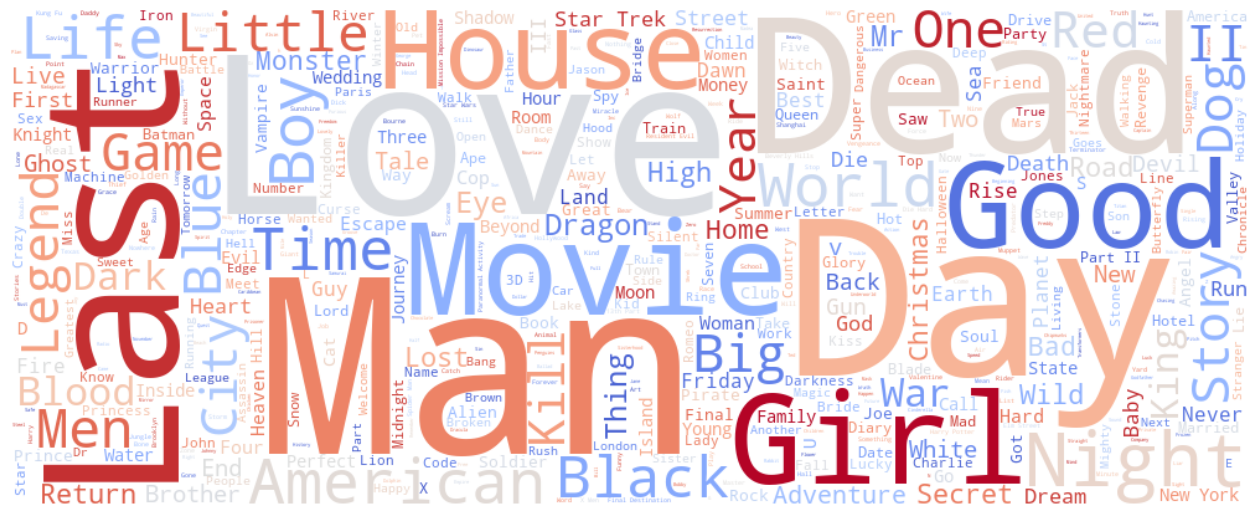

In [9]:
plt.figure(figsize = (16,8))
title_wordcloud = WordCloud (
                    stopwords=STOPWORDS,
                    background_color = 'white',
                    width = 1000,
                    height = 400,
                    colormap = 'coolwarm',
                    max_words=500,
                    contour_width=1).generate(' '.join(df['title']))

plt.imshow(title_wordcloud, interpolation= 'bilinear')
plt.axis('off')
plt.show()

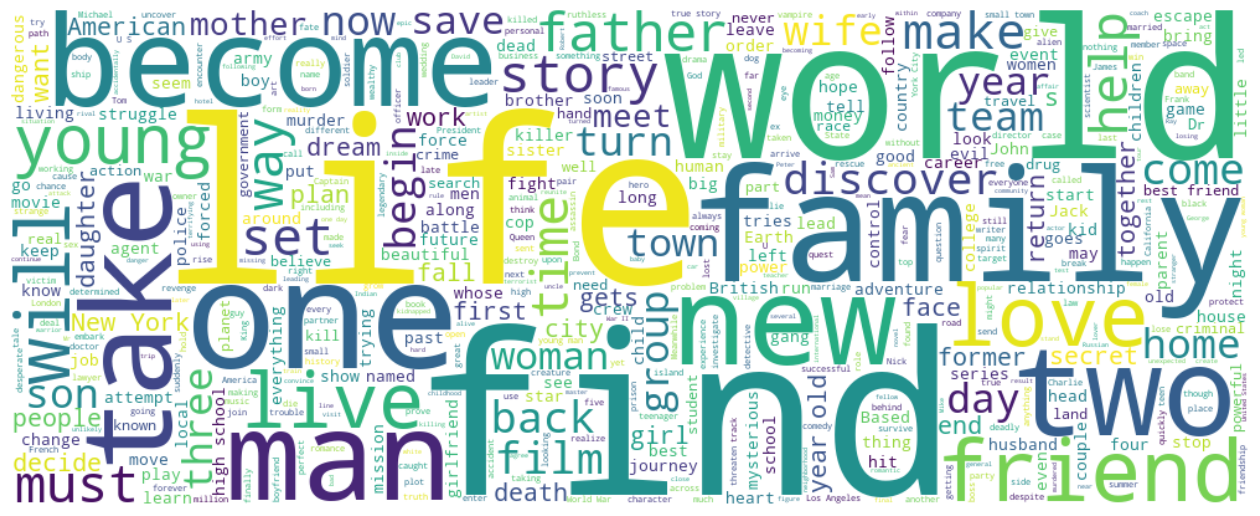

In [10]:
plt.figure(figsize = (16,8))
overview_wordcloud = WordCloud (
                    stopwords=STOPWORDS,
                    background_color = 'white',
                    width = 1000,
                    height = 400,
                    colormap = 'viridis',
                    max_words=500,
                    contour_width=1).generate(' '.join(df['overview']))

plt.imshow(overview_wordcloud, interpolation= 'bilinear')
plt.axis('off')
plt.show()

- The word "life”, ”world”, and “find”are significantly featured in movie overviews, while “Love” is a common word for movie titles. These word clouds offer valuable insights into popular movie themes.

### Popularity, Vote Average and Vote Count

In [11]:
def numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [12]:
df['popularity']= df['popularity'].apply(numeric)
df['vote_count']= df['vote_count'].apply(numeric)
df['vote_average']= df['vote_average'].apply(numeric)

#### Popularity

In [13]:
df['popularity'].describe()

count    4803.000000
mean       21.492301
std        31.816650
min         0.000000
25%         4.668070
50%        12.921594
75%        28.313505
max       875.581305
Name: popularity, dtype: float64

<Axes: ylabel='Frequency'>

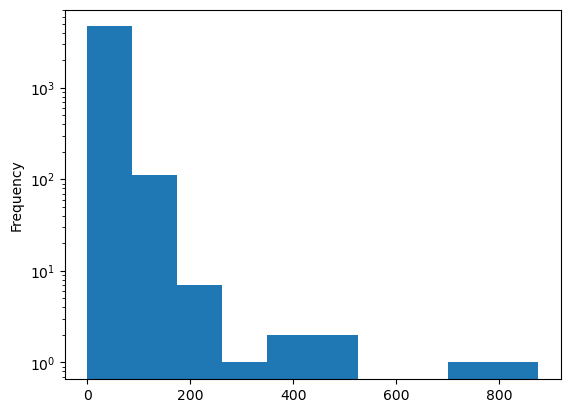

In [14]:
df['popularity'].plot(kind= 'hist', logy=True)

- The popularity scores exhibit a significant skew, with an average value of 21.5. However, there are instances of extreme values, such as 875, which is approximately 3942.5% higher than the mean.
- The majority of movies have popularity scores below 30, and even at the 75th percentile, the score is only 28.3.

**Most Popular Movies by Popularity Score**

In [15]:
df[['title', 'popularity', 'year']].sort_values('popularity', ascending=False).head(10)

,title,popularity,year
546,Minions,875.581305,2015
95,Interstellar,724.247784,2014
788,Deadpool,514.569956,2016
94,Guardians of the Galaxy,481.098624,2014
127,Mad Max: Fury Road,434.278564,2015
28,Jurassic World,418.708552,2015
199,Pirates of the Caribbean: The Curse of the Bla...,271.972889,2003
82,Dawn of the Planet of the Apes,243.791743,2014
200,The Hunger Games: Mockingjay - Part 1,206.227151,2014
88,Big Hero 6,203.734590,2014


- "Minions" leads the way as the most popular movie based on the Popularity Score. "Interstellar" and "Deadpool", two immensely popular movies, rank second and third, respectively.

#### Vote Counts

In [16]:
df['vote_count'].describe()

count     4803.000000
mean       690.217989
std       1234.585891
min          0.000000
25%         54.000000
50%        235.000000
75%        737.000000
max      13752.000000
Name: vote_count, dtype: float64

- Similar to the distribution of popularity scores, the distribution of vote counts also exhibits a notable skew. The median vote count is 235 votes, suggesting a relatively modest level of audience engagement. However, the most voted movie on the platform stands out with a remarkable 13,752 votes, showcasing a significant exception to the norm.

**Movies with the Highest Number of Votes**

In [17]:
df[['title', 'vote_count', 'year']].sort_values('vote_count', ascending=False).head(10)

,title,vote_count,year
96,Inception,13752.0,2010
65,The Dark Knight,12002.0,2008
0,Avatar,11800.0,2009
16,The Avengers,11776.0,2012
788,Deadpool,10995.0,2016
95,Interstellar,10867.0,2014
287,Django Unchained,10099.0,2012
94,Guardians of the Galaxy,9742.0,2014
426,The Hunger Games,9455.0,2012
127,Mad Max: Fury Road,9427.0,2015


- The top 10 movies with the highest number of votes include three remarkable works by Christopher Nolan: "Inception," "The Dark Knight," and "Interstellar." These films have garnered a substantial number of votes.

#### Vote Average

In [18]:
df['vote_average'].describe()

count    4803.000000
mean        6.092172
std         1.194612
min         0.000000
25%         5.600000
50%         6.200000
75%         6.800000
max        10.000000
Name: vote_average, dtype: float64

<Axes: xlabel='vote_average', ylabel='Density'>

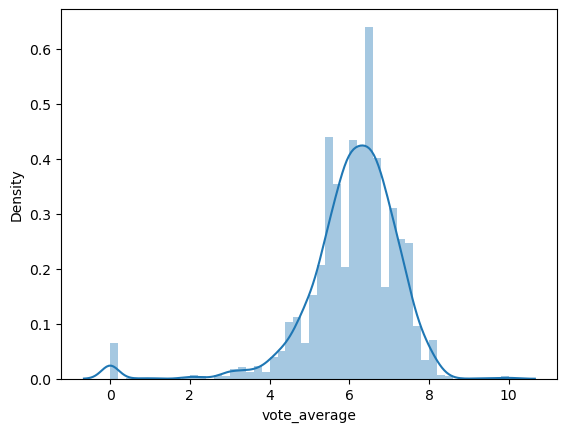

In [19]:
sns.distplot(df['vote_average'].fillna(df['vote_average'].median()))

- TMDB users tend to be quite moderate in their movie ratings, as reflected in a mean rating of 6 on a 10-point scale. Additionally, around 50% of the movies receive ratings around 6.2, indicating a balanced distribution of ratings with a slight tendency towards the positive side.

**Exploring the Correlation Between Vote Counts, Vote Average, and Popularity: A Scatterplot Analysis**

R Squared Value: 0.07504960440370911


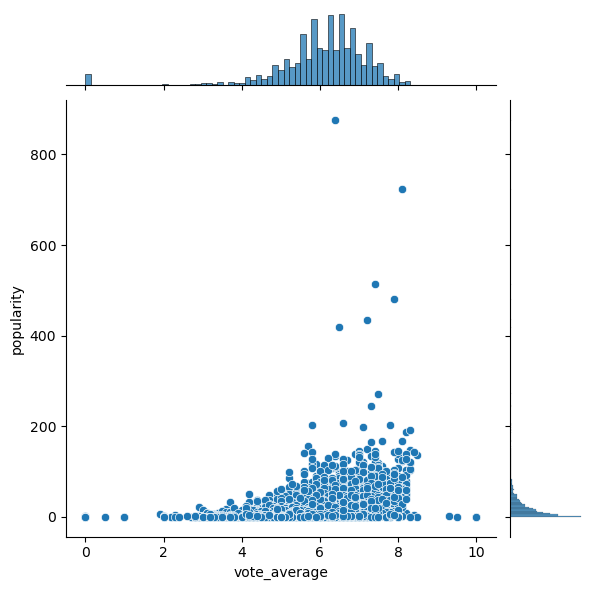

In [20]:
sns.jointplot(x='vote_average', y='popularity', data=df)
r_squared = df['vote_average'].corr(df['popularity'])**2
print("R Squared Value:", r_squared)

- The correlation coefficient, with a mere 0.075, strongly implies an almost non-existent connection between these two variables. This suggests that a movie's popularity and its vote average are independent variables.

R Squared Value: 0.09796737490808485


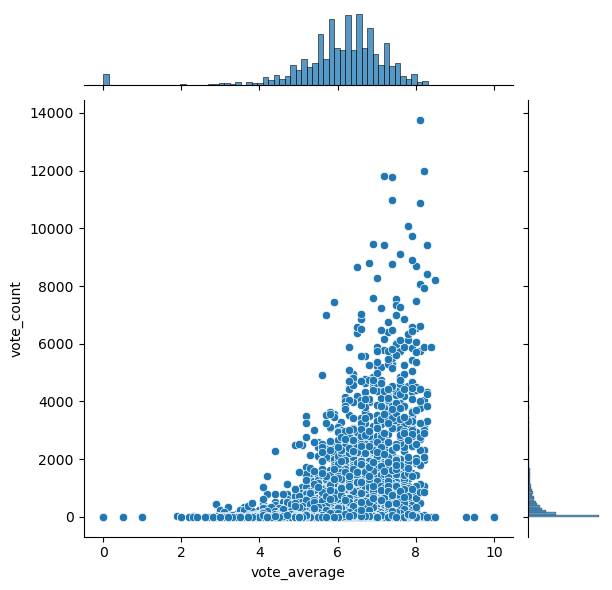

In [21]:
sns.jointplot(x='vote_average', y='vote_count', data=df)
r_squared = df['vote_average'].corr(df['vote_count'])**2
print("R Squared Value:", r_squared)

- Vote Count and Vote Average exhibit a very weak correlation. Having a high number of votes for a movie doesn't necessarily guarantee its quality.

## Top Movie Chart

I'll build our Top 200 Movies Chart using a weighted rating system inspired by IMDB. This system considers both the average rating and the number of votes a movie has received to rank them.

In summary:

**Weighted Rating (WR) = (v / (v+m)) * R + (m / (v+m)) * C**

Here's what these variables mean:

- **v** represents the number of votes for a movie.
- **m** is the minimum votes required to make it onto the chart.
- **R** is the average rating of the movie.
- **C** is the average vote across all movies in the dataset.

To qualify for our chart, a movie must have more votes than at least 95% of the movies in the list.

In [22]:
vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')

In [23]:
C= vote_averages.mean()
print("The mean of the voting averages:", C)
m= vote_counts.quantile(0.95)
print("The minimum vote count for a movie is:", m)

The mean of the voting averages: 5.6529252550489275
The minimum vote count for a movie is: 3040.8999999999996


To be considered for our chart, a movie must have a minimum of 3040 votes on TMDB, and the average rating for TMDB movies is 5.653.

In [24]:
qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['id','title', 'year', 'vote_count', 'vote_average', 'genres', 'popularity']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
print('The shape of the qualified database is: ',qualified.shape)

The shape of the qualified database is:  (241, 7)


In [25]:
def weighted_rating(x):
    v= x['vote_count']
    R= x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [26]:
qualified['weighted_rating']= qualified.apply(weighted_rating, axis=1)
qualified = qualified.sort_values('weighted_rating', ascending=False).head(200)

In [27]:
qualified.head(10)

,id,title,year,vote_count,vote_average,genres,popularity,weighted_rating
96,27205,Inception,2010,13752,8,"[Action, Thriller, Science Fiction, Mystery, A...",167.583710,7.574986
65,155,The Dark Knight,2008,12002,8,"[Drama, Action, Crime, Thriller]",187.322927,7.525542
95,157336,Interstellar,2014,10867,8,"[Adventure, Drama, Science Fiction]",724.247784,7.486823
662,550,Fight Club,1999,9413,8,[Drama],146.757391,7.426909
262,120,The Lord of the Rings: The Fellowship of the Ring,2001,8705,8,"[Adventure, Fantasy, Action]",138.049577,7.392365
3232,680,Pulp Fiction,1994,8428,8,"[Thriller, Crime]",121.463076,7.377689
1881,278,The Shawshank Redemption,1994,8205,8,"[Drama, Crime]",136.747729,7.365349
329,122,The Lord of the Rings: The Return of the King,2003,8064,8,"[Adventure, Fantasy, Action]",123.630332,7.357291
809,13,Forrest Gump,1994,7927,8,"[Comedy, Drama, Romance]",138.133331,7.349263
330,121,The Lord of the Rings: The Two Towers,2002,7487,8,"[Adventure, Fantasy, Action]",106.914973,7.322066


In [28]:
top_movies= qualified[['id', 'title', 'genres', 'weighted_rating', 'popularity', 'year']]
top_movies.head()

,id,title,genres,weighted_rating,popularity,year
96,27205,Inception,"[Action, Thriller, Science Fiction, Mystery, A...",7.574986,167.583710,2010
65,155,The Dark Knight,"[Drama, Action, Crime, Thriller]",7.525542,187.322927,2008
95,157336,Interstellar,"[Adventure, Drama, Science Fiction]",7.486823,724.247784,2014
662,550,Fight Club,[Drama],7.426909,146.757391,1999
262,120,The Lord of the Rings: The Fellowship of the Ring,"[Adventure, Fantasy, Action]",7.392365,138.049577,2001


- add discover

## Content Based Filtering System

I will develop two separate content-based filtering systems: one emphasizing movie genres, and the other centered around comprehensive movie descriptions, which include taglines, keywords, and overviews, offering an in-depth narrative summary of each film.

### Genre-Based Movie Recommendations:

- This model takes the movie title as input and identifies the first genre associated with the movie. It then provides recommendations of other movies that share this genre with the user.

In [29]:
df['weighted_rating']= df.apply(weighted_rating, axis=1)

In [30]:
g= df['genres'].apply(lambda x: pd.Series(x)).stack().reset_index(level=1, drop=True)
g.name= 'genre'
df= df.drop('genres', axis=1) 
genre_df= df.join(g)

In [31]:
genre_df.head()

,id,title,overview,tagline,keywords,popularity,vote_average,vote_count,year,weighted_rating,genre
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...",Enter the World of Pandora.,"[culture clash, future, space war, space colon...",150.437577,7.2,11800.0,2009,6.883004,Action
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...",Enter the World of Pandora.,"[culture clash, future, space war, space colon...",150.437577,7.2,11800.0,2009,6.883004,Adventure
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...",Enter the World of Pandora.,"[culture clash, future, space war, space colon...",150.437577,7.2,11800.0,2009,6.883004,Fantasy
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...",Enter the World of Pandora.,"[culture clash, future, space war, space colon...",150.437577,7.2,11800.0,2009,6.883004,Science Fiction
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","At the end of the world, the adventure begins.","[ocean, drug abuse, exotic island, east india ...",139.082615,6.9,4500.0,2007,6.397112,Adventure


In [32]:
def simple_recommendations(title):

    input_genre = genre_df[genre_df['title'] == title]['genre'].tolist()[0]
    
    movies = genre_df[genre_df['genre'] == input_genre][['title', 'year', 'popularity','weighted_rating']]
    
    movies= movies.sort_values('weighted_rating', ascending=False).head(10)
    
    return movies

In [33]:
simple_recommendations('The Dark Knight')

,title,year,popularity,weighted_rating
1881,The Shawshank Redemption,1994,136.747729,7.730149
65,The Dark Knight,2008,187.322927,7.685113
662,Fight Club,1999,146.757391,7.653657
95,Interstellar,2014,724.247784,7.564958
809,Forrest Gump,1994,138.133331,7.493812
3337,The Godfather,1972,143.659698,7.464957
287,Django Unchained,2012,82.121691,7.303113
77,Inside Out,2015,128.655964,7.256609
1818,Schindler's List,1993,104.469351,7.207788
3865,Whiplash,2014,192.528841,7.196559


- Depending on the first genre in the movie title alone offers limited information. Users may not be familiar with the precise genre, and since many movies fall into multiple genres, it can lead to recommendations that overlap with the input title.

### Description-Based Movie Recommender:

- This model takes movie titles as input and employs movie keywords, overviews and taglines as descriptions. It leverages cosine similarity to identify similar movies for users. This approach is expected to provide more accurate recommendations compared to the previous model.

**Combine the "keywords", "tagline" and "overview" columns as "description" for our recommender system.**

In [34]:
df['keywords']= df['keywords'].astype('str')

In [35]:
df['description'] = df['overview'].fillna(" ") + " " + df['tagline'].fillna('')+ df['keywords'].fillna('')

**TfidfVectorizer**

TfidfVectorizer streamlines all three stages (word count computation, IDF value calculation, and TF-IDF score generation) into a single operation, enhancing efficiency.

The **tfidf_matrix** is structured with rows representing the input data and their associated TF-IDF scores for different word combinations within the corpus. To clarify, TF-IDF stands for Term Frequency-Inverse Document Frequency, a widely used algorithm for converting text into a meaningful numerical representation. It is employed to train machine learning models for predictive purposes. While Count Vectorizer provides word frequency based on the vocabulary index, TF-IDF takes into account the overall document weight of words.

In [36]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df['description'])

**Cosine Similarity**

- As we've employed the TF-IDF Vectorizer, we can obtain the Cosine Similarity Score directly by calculating the Dot Product, making it more efficient than using cosine_similarities. 

In [37]:
tfidf_matrix.shape

(4803, 373641)

In [38]:
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [39]:
%%time
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)
cosine_sim[1]

CPU times: user 157 ms, sys: 28.9 ms, total: 186 ms
Wall time: 196 ms


array([0.00208924, 1.        , 0.        , ..., 0.00422178, 0.00241474,
       0.        ])

In [40]:
cosine_sim.shape

(4803, 4803)

In [41]:
df = df.reset_index()
indices = pd.Series(df.index, index=df['title'])

In [42]:
def improved_recommendations(title):
    index = indices[title]
    sim_scores = list(enumerate(cosine_sim[index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_index= [i[0] for i in sim_scores]
    
    movies = df.iloc[movie_index][['title', 'year', 'popularity','weighted_rating']]
    movies= movies.sort_values('weighted_rating', ascending=False).head(10)

    return  movies

In [43]:
improved_recommendations('The Godfather')

,title,year,popularity,weighted_rating
2731,The Godfather: Part II,1974,105.792936,7.038107
1847,GoodFellas,1990,63.654244,6.944444
2038,Summer of Sam,1999,3.707890,5.675911
1873,Blood Ties,2013,12.756344,5.671403
3727,Easy Money,2010,7.217328,5.670118
3623,Made,2001,4.149628,5.664421
3293,10th & Wolf,2006,3.942464,5.657992
3960,The Deported,2010,0.194848,5.652925
3760,The Jerky Boys,1995,1.735462,5.650130
3859,Lords of London,2014,1.913302,5.648883


In [44]:
improved_recommendations('The Dark Knight')

,title,year,popularity,weighted_rating
3,The Dark Knight Rises,2012,112.312950,7.112562
119,Batman Begins,2005,115.040024,6.959921
205,Sherlock Holmes: A Game of Shadows,2011,81.499621,6.408636
1359,Batman,1989,44.104469,6.202570
428,Batman Returns,1992,59.113174,5.989049
813,Superman,1978,48.507081,5.966620
3854,"Batman: The Dark Knight Returns, Part 2",2013,25.891466,5.925050
9,Batman v Superman: Dawn of Justice,2016,155.790452,5.685749
299,Batman Forever,1995,48.205606,5.503444
210,Batman & Robin,1997,50.073575,5.190872


- Utilizing cosine similarity on movie descriptions improves the precision of recommendation outputs when compared to solely depending on genre information.

### Model Evaluation

- The **initial recommendation model** utilizes a straightforward approach where movies are recommended based on the first genre category associated with the input movie. However, this simplistic method may lead to less accurate recommendations, as movies can belong to multiple genre categories. As a consequence, the system might suggest movies that are already similar to the input title.

- The **optimized recommendation model** involves leveraging a TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer to compute the similarity between movie descriptions, which includes keywords, taglines and overviews. The primary objective is to employ cosine similarity as the metric for quantifying the degree of similarity between different movies. This approach enhances the recommendation system's effectiveness by identifying movies with similar content and suggesting them as recommendations. By using TF-IDF to represent textual data and cosine similarity to measure the closeness between movies, the system can provide valuable recommendations based on textual content and user preferences. This optimized method significantly improves the accuracy and relevance of movie recommendations.

- With ongoing user interactions and feedback on the recommendations, the recommendation engine continually refines its accuracy. Leveraging the user profile and the engine's growing comprehension of user preferences, the system consistently delivers personalized and highly relevant recommendations to each individual user.

### Export DataFrames to SQLite Database

In [45]:
top_movies['genres'] = top_movies['genres'].apply(json.dumps)

In [46]:
engine = create_engine('sqlite:///moviemood.db')

In [47]:
df.to_sql('movies', engine, if_exists='replace', index=False)

4803

In [48]:
top_movies.to_sql('top_movies', engine, if_exists='replace', index=False)

200

In [49]:
engine.dispose()

### Save the Model

In [50]:
# Save the TF-IDF model
pickle.dump(tf, open('models/tfidf_vectorizer.pickle','wb'), protocol=pickle.HIGHEST_PROTOCOL)